### Load  and filter data

In [1]:
from topicnet.cooking_machine import Dataset

demo_data = Dataset('wiki_data.csv', batch_vectorizer_path="./wiki_batches")


In [2]:
demo_data._cached_dict = demo_data.get_dictionary().filter(min_df=5.0, min_tf=5.0, max_df_rate=0.9)

In [3]:
demo_data.get_dataset().head()

,Unnamed: 0,raw_text,vw_text
id,,,
İsmet_İnönü,0,Mustafa İsmet İnönü (September 24 1884 – Decem...,İsmet_İnönü |@lemmatized mustafa:2 smet:7 nönü...
Clara_Petacci,1,Clara Petacci (Claretta Petacci) (28 February ...,Clara_Petacci |@lemmatized clara:5 petacci:15 ...
Jack_Ruby,2,"Jacob Rubenstein (March 25, 1911 – January 3, ...",Jack_Ruby |@lemmatized jacob:2 rubenstein:5 ma...
Knud_Rasmussen,3,"Knud Johan Victor Rasmussen (June 7, 1879–Dece...",Knud_Rasmussen |@lemmatized knud:15 johan:3 vi...
Gerald_Schroeder,4,"Gerald L. Schroeder is a scientist, author, an...",Gerald_Schroeder |@lemmatized gerald:4 l:1 sch...


### Constructing inital Topic Model

In [4]:
from topicnet.cooking_machine.model_constructor import init_simple_default_model

model_artm = init_simple_default_model(
    dataset=demo_data,
    modalities_to_use={'@lemmatized': 1.0, '@bigram': 1.0},
    main_modality='@lemmatized',
    specific_topics=15,
    background_topics=1,
)

model_artm.scores

[PerplexityScore@all, SparsityThetaScore, SparsityPhiScore@lemmatized, PerplexityScore@lemmatized, TopicKernel@lemmatized, SparsityPhiScore@bigram, PerplexityScore@bigram, TopicKernel@bigram]

### Defining root model and experiment

In [5]:
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.experiment import Experiment

In [6]:
tm = TopicModel(model_artm)

In [7]:
specific_topics = [t for t in tm.topic_names if "background" not in t]

In [8]:
model_artm.regularizers

[smooth_phi_bcg, smooth_theta_bcg]

In [9]:
model_artm.scores

[PerplexityScore@all, SparsityThetaScore, SparsityPhiScore@lemmatized, PerplexityScore@lemmatized, TopicKernel@lemmatized, SparsityPhiScore@bigram, PerplexityScore@bigram, TopicKernel@bigram]

In [10]:
experiment = Experiment(experiment_id="wiki_experiment", save_path="rtl_wiki/experiments", topic_model=tm)

In [11]:
from topicnet.cooking_machine.cubes import CubeCreator, RegularizersModifierCube, PerplexityStrategy, GreedyStrategy

In [12]:
import artm

In [13]:

my_first_cube = RegularizersModifierCube(
    num_iter=10,
    regularizer_parameters=[
        {
            'regularizer': artm.DecorrelatorPhiRegularizer(name='decorrelation_phi', 
                                                           class_ids="@lemmatized", 
                                                           topic_names=specific_topics),
            'tau_grid': [0, 0.005, 0.01, 0.015, 0.02, 0.025]
        },
        {
            'regularizer': artm.SmoothSparsePhiRegularizer(name="smsp_phi_specific",
                                                           class_ids="@lemmatized", 
                                                           topic_names=specific_topics),
            'tau_grid': [-0.05, 0, 0.05]
        },
        {
            'name': "smooth_phi_bcg",
            'tau_grid': [0.1]
        },
    ],
    verbose=True
)
my_first_cube(tm, demo_data)

100%|██████████| 18/18 [06:53<00:00, 22.95s/it]


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

from topicnet.cooking_machine.pretty_output import make_notebook_pretty
make_notebook_pretty()


In [15]:
experiment.show()

Experiment wiki_experiment

Experiment was made with BigARTM 0.9.0
Tree:
                              ┌##17h46m43s_24d10m2019y###
                              ├##17h47m05s_24d10m2019y###
                              ├##17h47m28s_24d10m2019y###
                              ├##17h47m51s_24d10m2019y###
                              ├##17h48m14s_24d10m2019y###
                              ├##17h48m37s_24d10m2019y###
                              ├##17h48m59s_24d10m2019y###
                              ├##17h49m23s_24d10m2019y###
                              ├##17h49m46s_24d10m2019y###
<<<<<<<<<<<root>>>>>>>>>>>────┤
                              ├##17h50m09s_24d10m2019y###
                              ├##17h50m32s_24d10m2019y###
                              ├##17h50m55s_24d10m2019y###
                              ├##17h51m18s_24d10m2019y###
                              ├##17h51m41s_24d10m2019y###
                              ├##17h52m04s_24d10m2019y###
                         

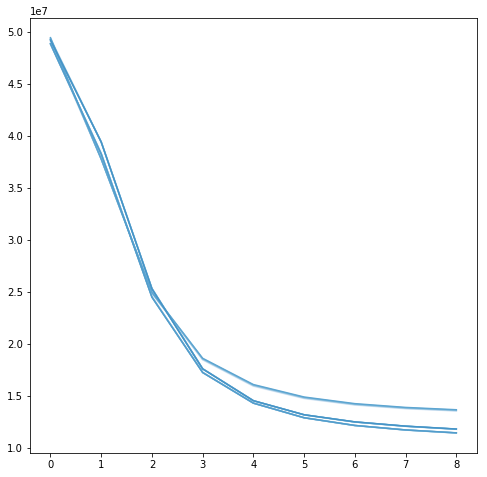

In [16]:
from matplotlib import cm
import numpy as np


tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['PerplexityScore@all']
    plt.plot(score[1:], color=cm.Blues(colors[i]))
plt.show()

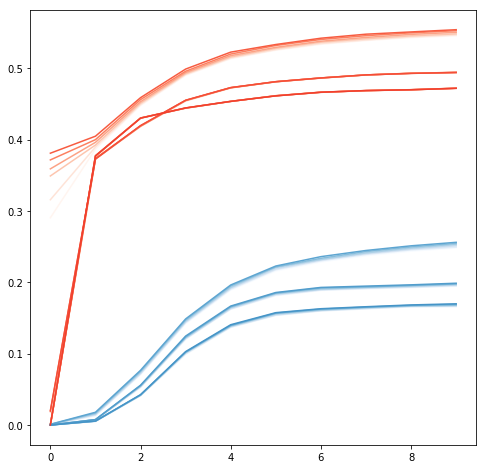

In [17]:
from matplotlib import cm
import numpy as np


tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['TopicKernel@lemmatized.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]))
    score = tm.scores['TopicKernel@lemmatized.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]))
plt.show()

In [18]:
query = (
    "TopicKernel@lemmatized.average_contrast > 0.7 * MAXIMUM(TopicKernel@lemmatized.average_contrast) "
    "and TopicKernel@lemmatized.average_purity > 0.7 * MAXIMUM(TopicKernel@lemmatized.average_purity) "
    "and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all) "
)
models = experiment.select(query)

models = experiment.select(query + " COLLECT all")
print(len(models))

6


In [19]:
def describe_model(model):
    for reg_name, reg in model.regularizers._data.items():
        print(reg_name, reg.tau)
    print(model.scores["PerplexityScore@all"][-1])
    print(model.scores["TopicKernel@lemmatized.average_contrast"][-1])
    print(model.scores["TopicKernel@lemmatized.average_purity"][-1])
    print("------")

In [20]:
for model in models:
    describe_model(model)

smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0
smsp_phi_specific 0.0
11431396.0
0.49426960945129395
0.19459345936775208
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0.005
smsp_phi_specific 0.0
11433357.0
0.49436870217323303
0.195402130484581
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0.01
smsp_phi_specific 0.0
11436253.0
0.49431541562080383
0.1962587833404541
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0.015
smsp_phi_specific 0.0
11440095.0
0.4943116009235382
0.19706884026527405
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0.02
smsp_phi_specific 0.0
11444871.0
0.4941447973251343
0.19780972599983215
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0.025
smsp_phi_specific 0.0
11450295.0
0.49418962001800537
0.19877628982067108
------


The models are really close. However, last 2 look better. Let's take a closer look at one of them.

In [21]:
query = (
    "TopicKernel@lemmatized.average_contrast > 0.7 * MAXIMUM(TopicKernel@lemmatized.average_contrast) "
    "and TopicKernel@lemmatized.average_purity > 0.7 * MAXIMUM(TopicKernel@lemmatized.average_purity) "
    "and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all) "
    "and TopicKernel@lemmatized.average_purity -> max"    
)

models = experiment.select(query + " COLLECT 2")
print(len(models))

2


In [22]:
last_model = models[-1]

This is optional, but encouraged: let's log our selection criteria, so Experiment "knows" how exactly models were chosen.


In [25]:
experiment.set_criteria(cube_index=1, criteria=query + " COLLECT 2")
experiment.show()

Experiment wiki_experiment

Experiment was made with BigARTM 0.9.0
Tree:
                              ┌##17h46m43s_24d10m2019y###
                              ├##17h47m05s_24d10m2019y###
                              ├##17h47m28s_24d10m2019y###
                              ├##17h47m51s_24d10m2019y###
                              ├##17h48m14s_24d10m2019y###
                              ├##17h48m37s_24d10m2019y###
                              ├##17h48m59s_24d10m2019y###
                              ├##17h49m23s_24d10m2019y###
                              ├##17h49m46s_24d10m2019y###
<<<<<<<<<<<root>>>>>>>>>>>────┤
                              ├##17h50m09s_24d10m2019y###
                              ├##17h50m32s_24d10m2019y###
                              ├##17h50m55s_24d10m2019y###
                              ├##17h51m18s_24d10m2019y###
                              ├##17h51m41s_24d10m2019y###
                              ├##17h52m04s_24d10m2019y###
                         

Looks better this way, doesn't it?

### Investigate model 

In [26]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer

In [27]:
last_model_top_tok = TopTokensViewer(last_model, num_top_tokens=10, method='phi')
last_model_html = last_model_top_tok.to_html()


In [28]:
last_model_top_doc = TopDocumentsViewer(last_model, dataset=demo_data).view()


In [29]:
from IPython.display import display, display_html


In [30]:
n=7
for topic_name, topic_docs in list(zip(last_model.topic_names, last_model_top_doc))[:n]:
    last_model_html = last_model_top_tok.to_html(topic_names=[topic_name])
    display_html(last_model_html, raw=True)
    display(topic_docs)

,topic_0 @bigram
united_state,0.01469
bin_laden,0.01366
new_york,0.00923
http_www,0.00811
al_qaeda,0.00802
south_africa,0.00776
york_time,0.00767
prime_minister,0.00552
ahmad_shah,0.00497
west_indie,0.00451


['Osama_bin_Laden',
 'Brian_Lara',
 'Abu_Zubaydah',
 'Hansie_Cronje',
 'Nawaf_al-Hazmi',
 'Bal_Thackeray',
 'Ian_Botham',
 'Kenneth_Kaunda',
 'Daniel_Ortega',
 'Ariel_Sharon']

,topic_1 @bigram
new_york,0.01782
st_john,0.01128
john_baptist,0.00977
anglo_saxon,0.00743
mary_magdalene,0.00704
st_martin,0.00612
st_louis,0.00471
john_chrysostom,0.0045
external_link,0.00419
new_testament,0.00418


['John_the_Baptist',
 'Elijah',
 'Ã%86lfheah_of_Canterbury',
 'Matthew_the_Apostle',
 'Mary_Magdalene',
 'John_the_Evangelist',
 'Augustine_of_Canterbury',
 'Michael_Jordan',
 'Moses',
 'Barnabas']

,topic_2 @bigram
henry_viii,0.01146
new_york,0.00559
henry_vii,0.00363
royal_navy,0.00336
united_state,0.00331
major_league,0.00317
third_reich,0.00306
prince_wale,0.00287
edward_vi,0.0028
king_henry,0.00264


['Charles_Robert_Malden',
 'Horatio_Nelson,_1st_Viscount_Nelson',
 'Mary_I_of_England',
 'Henry_VIII_of_England',
 'Francis_Drake',
 'Catherine_of_Aragon',
 'Arthur_Phillip',
 'John_Paul_Jones',
 'Elihu_Yale',
 'Henry_the_Navigator']

,topic_3 @bigram
science_fiction,0.02782
short_story,0.0259
new_york,0.00953
grand_slam,0.0067
french_open,0.00561
u_open,0.00518
james_joyce,0.00482
external_link,0.00454
henry_ford,0.00452
australian_open,0.00445


['Björn_Borg',
 'James_Tiptree,_Jr',
 'Martina_Hingis',
 'Clark_Ashton_Smith',
 'James_Blaylock',
 'Fritz_Leiber',
 'A',
 'Patrick_Rafter',
 'Andre_Agassi',
 'Anna_Kournikova']

,topic_4 @bigram
louis_xiv,0.00774
roman_empire,0.00523
imperial_prince,0.00429
roman_emperor,0.0039
holy_roman,0.0038
imperial_princess,0.00377
new_york,0.00374
without_issue,0.00362
ottoman_empire,0.00349
emperor_japan,0.0032


['Emperor_Montoku',
 'Emperor_Seiwa',
 'Emperor_Junna',
 'Emperor_Bidatsu',
 'Emperor_Sushun',
 'Emperor_Monmu',
 'Emperor_Kazan',
 'Emperor_Uda',
 'Emperor_Kanmu',
 "Emperor_Go-En'yū"]

,topic_5 @bigram
new_york,0.0154
r_b,0.00675
external_link,0.0063
retrieve_january,0.00564
united_state,0.00435
u_r,0.00407
string_quartet,0.00397
york_city,0.00395
retrieve_march,0.00394
flat_major,0.00374


['Carl_Friedrich_Abel',
 'Georg_Philipp_Telemann',
 'Alberto_Giacometti',
 'Karl_Benz',
 'Franz_Schmidt',
 'Edvard_Grieg',
 'Dale_Chihuly',
 'Mario_Botta',
 'Anton_Diabelli',
 'Frédéric_Chopin']

,topic_6 @bigram
new_york,0.01994
university_press,0.01056
nobel_prize,0.00879
united_state,0.00716
external_link,0.00611
press_isbn,0.0055
see_also,0.00493
university_chicago,0.00385
academy_science,0.00376
columbia_university,0.00358


['Grigory_Barenblatt',
 'Brian_Kernighan',
 'James_Heckman',
 'Karl_Ferdinand_Braun',
 'Dennis_Ritchie',
 'Ernst_Mayr',
 'Heinrich_Hertz',
 'John_Bardeen',
 'Karl_Popper',
 'Charles_F']

The topics aren't ideal, but adequate.

We see topics related to kings (and Muslim rulers), religious figures (and sportsmen: `'jordan'` refers both to Jordan River and Michael Jordan), emperors, writers, composers, mathematicians/philosophers/scientists. 

In [31]:
last_model_html = last_model_top_tok.to_html(topic_names=['background_15'])
display_html(last_model_html, raw=True)
    
topic_docs = last_model_top_doc[-1]
topic_docs = [str(topic) for topic in topic_docs]
for doc_id in topic_docs:
    print(doc_id)


,background_15 @bigram
prime_minister,0.02166
world_war,0.01223
von_neumann,0.00784
united_kingdom,0.00642
foreign_policy,0.00514
labour_party,0.00463
war_ii,0.00438
general_election,0.0038
nova_scotia,0.00376
conservative_party,0.00371


Mackenzie_Bowell
Charles_Tupper
Louis_St
Neville_Chamberlain
Clement_Attlee
Alexander_Mackenzie
Benjamin_Disraeli
Kurt_Georg_Kiesinger
Henry_Bruce,_1st_Baron_Aberdare
Michael_Foot


## Let's improve document-topic distribution

In [34]:

theta_cube = RegularizersModifierCube(
    num_iter=10,
    regularizer_parameters=[
        {
            'regularizer': artm.SmoothSparseThetaRegularizer(name="smsp_theta_specific",
                                                           topic_names=specific_topics),
            'tau_grid': [-0.05, -0.01]
        },
        {
            'name': "smooth_theta_bcg",
            'tau_grid': [0.01, 0.1]
        },
    ],
    verbose=True
)
theta_cube(models, demo_data)

experiment.show()

Experiment wiki_experiment

Experiment was made with BigARTM 0.9.0
Tree:
                              ┌##17h46m43s_24d10m2019y###
                              ├##17h47m05s_24d10m2019y###
                              ├##17h47m28s_24d10m2019y###
                              ├##17h47m51s_24d10m2019y###
                              ├##17h48m14s_24d10m2019y###
                              ├##17h48m37s_24d10m2019y###
                              ├##17h48m59s_24d10m2019y###
                              ├##17h49m23s_24d10m2019y###
                              ├##17h49m46s_24d10m2019y###
<<<<<<<<<<<root>>>>>>>>>>>────┤
                              ├##17h50m09s_24d10m2019y###
                              ├##17h50m32s_24d10m2019y###
                              ├##17h50m55s_24d10m2019y###
                              ├##17h51m18s_24d10m2019y###
                              │                                                                                                      ┌##18h13

In [36]:
query = (
    "TopicKernel@lemmatized.average_contrast > 0.95 * MAXIMUM(TopicKernel@lemmatized.average_contrast) "
    "and TopicKernel@lemmatized.average_purity > 0.95 * MAXIMUM(TopicKernel@lemmatized.average_purity) "
    "and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all) "
    "and SparsityThetaScore > MEDIAN(SparsityThetaScore)"
)
models = experiment.select(query)

print(len(models))

4


In [37]:
for model in models:
    describe_model(model)

smooth_phi_bcg 0.1
smooth_theta_bcg 0.01
decorrelation_phi 0.025
smsp_phi_specific 0.0
smsp_theta_specific -9.111882954680624
10380279.0
0.49794384837150574
0.19310863316059113
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.1
decorrelation_phi 0.025
smsp_phi_specific 0.0
smsp_theta_specific -9.111882954680624
10380976.0
0.4979652762413025
0.1931198388338089
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.01
decorrelation_phi 0.02
smsp_phi_specific 0.0
smsp_theta_specific -9.111882954680624
10373520.0
0.49823978543281555
0.19223743677139282
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.1
decorrelation_phi 0.02
smsp_phi_specific 0.0
smsp_theta_specific -9.111882954680624
10374009.0
0.4982163906097412
0.1922537386417389
------


In [38]:
best_model = models[0]

### Investigate model 

In [39]:
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html()
first_model_top_doc = TopDocumentsViewer(best_model, dataset=demo_data).view()

In [40]:
n=7
for topic_name, topic_docs in list(zip(best_model.topic_names, first_model_top_doc))[:n]:
    best_model_html = first_model_top_tok.to_html(topic_names=[topic_name])
    display_html(best_model_html, raw=True)
    display(topic_docs)

,topic_0 @bigram
united_state,0.01555
bin_laden,0.0137
new_york,0.01089
al_qaeda,0.00805
york_time,0.00774
south_africa,0.00735
http_www,0.00601
sri_lanka,0.00516
ahmad_shah,0.00499
west_indie,0.00445


['Hansie_Cronje',
 'Brian_Lara',
 'Abdulaziz_al-Omari',
 'Nawaf_al-Hazmi',
 'Osama_bin_Laden',
 'Ahmed_al-Nami',
 'Majed_Moqed',
 'Mark_Bingham',
 'Abu_Zubaydah',
 'Hani_Hanjour']

,topic_1 @bigram
new_york,0.01564
st_john,0.00991
john_baptist,0.00894
anglo_saxon,0.00733
mary_magdalene,0.00675
st_martin,0.00532
feast_day,0.00482
new_testament,0.0048
john_chrysostom,0.00455
catholic_church,0.00446


['Mary_Magdalene',
 'Matthew_the_Apostle',
 'John_the_Evangelist',
 'John_the_Baptist',
 'Barnabas',
 'Ã%86lfheah_of_Canterbury',
 'John_Climacus',
 'Luke_the_Evangelist',
 'Saint_Titus',
 'Augustine_of_Canterbury']

,topic_2 @bigram
henry_viii,0.0116
new_york,0.00439
henry_vii,0.00369
royal_navy,0.00327
king_henry,0.00295
prince_wale,0.00278
united_state,0.0027
edward_vi,0.0027
press_isbn,0.00257
civil_war,0.00257


['Ferdinand_Magellan',
 'Mary_I_of_England',
 'Diego_de_Almagro',
 'Francis_Drake',
 'Henry_the_Navigator',
 'Charles_Robert_Malden',
 'Henry_VIII_of_England',
 'Horatio_Nelson,_1st_Viscount_Nelson',
 'Catherine_of_Aragon',
 'John_Paul_Jones']

,topic_3 @bigram
science_fiction,0.02435
short_story,0.02242
new_york,0.00859
grand_slam,0.00611
french_open,0.00511
u_open,0.00472
external_link,0.00438
james_joyce,0.00423
http_www,0.00416
henry_ford,0.00411


['Björn_Borg',
 'Dan_Simmons',
 'Clark_Ashton_Smith',
 'Lois_McMaster_Bujold',
 'James_Tiptree,_Jr',
 'Larry_Niven',
 'Martina_Hingis',
 'C',
 'K',
 'Eden_Phillpotts']

,topic_4 @bigram
louis_xiv,0.00885
imperial_prince,0.00471
nicholas_ii,0.00428
imperial_princess,0.00414
holy_roman,0.00402
new_york,0.00393
ottoman_empire,0.00348
emperor_japan,0.00346
court_lady,0.00329
without_issue,0.00327


['Emperor_Seiwa',
 'Emperor_Kanmu',
 'Emperor_Montoku',
 'Emperor_Saga',
 'Emperor_Uda',
 'Emperor_Tenmu',
 'Emperor_Kazan',
 'Emperor_Monmu',
 'Emperor_Junna',
 'Emperor_Kinmei']

,topic_5 @bigram
new_york,0.01406
external_link,0.00607
u_r,0.00394
string_quartet,0.00387
world_war,0.00383
retrieve_january,0.00374
flat_major,0.00363
york_city,0.00338
g_major,0.0032
modern_art,0.00313


['Carl_Friedrich_Abel',
 'Edvard_Grieg',
 'Georges_Braque',
 'Anton_Diabelli',
 'Gilles_Apap',
 'Johann_Friedrich_Agricola',
 'Dale_Chihuly',
 'Matteo_Carcassi',
 'Kenneth_Noland',
 'Lyonel_Feininger']

,topic_6 @bigram
new_york,0.01489
university_press,0.00889
nobel_prize,0.00805
united_state,0.00661
external_link,0.00618
press_isbn,0.00495
see_also,0.0047
academy_science,0.00337
university_chicago,0.00325
columbia_university,0.00305


['Marvin_Minsky',
 'Dennis_Ritchie',
 'David_Deutsch',
 'Brian_Kernighan',
 'Grigory_Barenblatt',
 'Murray_Gell-Mann',
 'Kenneth_Lee_Pike',
 'Charles_F',
 'Diedrich_Hermann_Westermann',
 'Fred_Brooks']

The topics are slightly better: `michael jordan` is gone from top documents for religion.

In [42]:
experiment.set_criteria(cube_index=2, criteria=query)
experiment.show()

Experiment wiki_experiment

Experiment was made with BigARTM 0.9.0
Tree:
                              ┌##17h46m43s_24d10m2019y###
                              ├##17h47m05s_24d10m2019y###
                              ├##17h47m28s_24d10m2019y###
                              ├##17h47m51s_24d10m2019y###
                              ├##17h48m14s_24d10m2019y###
                              ├##17h48m37s_24d10m2019y###
                              ├##17h48m59s_24d10m2019y###
                              ├##17h49m23s_24d10m2019y###
                              ├##17h49m46s_24d10m2019y###
<<<<<<<<<<<root>>>>>>>>>>>────┤
                              ├##17h50m09s_24d10m2019y###
                              ├##17h50m32s_24d10m2019y###
                              ├##17h50m55s_24d10m2019y###
                              ├##17h51m18s_24d10m2019y###
                              │                                                                                                      ┌##18h13